| Task                | Complexity     | Runtime     | Result size          |
|----------------------|----------------|--------------|----------------------|
| Build index          | O(N log N)     | <1 s         | in-memory            |
| Precompute neighbors | O(N × K)       | ~1–2 min     | ~2–3 MB CSV          |
| Lookup from file     | O(1)           | microseconds | dictionary lookup    |


In [34]:
import geopandas as gpd
from shapely.geometry import Polygon
import pandas as pd
from tqdm import tqdm  # optional progress bar

gdf = gpd.read_file("nyc_tracts/nyc_tracts.json")
if gdf.crs is None:
    gdf.set_crs(epsg=2263, inplace=True)

# Keep only needed columns
gdf = gdf[["GEOID", "geometry"]].rename(columns={"GEOID": "tract_id"})

# Shorten to last 7 digits (strip '36' state and '061' county code)
gdf["tract_id"] = gdf["tract_id"].str[-7:]
gdf.reset_index(drop=True, inplace=True)

print("Tracts loaded:", len(gdf))


Tracts loaded: 2325


In [35]:
sindex = gdf.sindex


In [36]:
def get_neighbors(tract_geom, sindex, gdf, X_miles=1):
    buffer_geom = tract_geom.buffer(X_miles * 5280)
    candidate_idx = list(sindex.intersection(buffer_geom.bounds))
    candidates = gdf.iloc[candidate_idx]
    nearby = candidates[candidates.intersects(buffer_geom)]
    return nearby["tract_id"].tolist()

neighbors = {}

for idx, row in tqdm(gdf.iterrows(), total=len(gdf)):
    tract_id = row["tract_id"]
    neighbors[tract_id] = get_neighbors(row["geometry"], sindex, gdf, X_miles=1)


100%|████████████████████████████████████████████████| 2325/2325 [00:14<00:00, 163.95it/s]


In [37]:
# Convert to DataFrame for easier export
df_neighbors = pd.DataFrame([
    {"tract_id": tid, "neighbor_ids": ",".join(nlist)}
    for tid, nlist in neighbors.items()
])

df_neighbors.to_csv("output/nyc_tract_neighbors_1mile.csv", index=False)
print("Saved to output/nyc_tract_neighbors_1mile.csv")

Saved to output/nyc_tract_neighbors_1mile.csv


In [9]:
# neighbors_df = pd.read_csv("nyc_tract_neighbors_1mile.csv")

# # Turn back into dict for fast lookups
# neighbors_dict = {
#     row["tract_id"]: row["neighbor_ids"].split(",")
#     for _, row in neighbors_df.iterrows()
# }

# # Example usage
# neighbors_dict["1000100"]

In [38]:
import json
with open("output/nyc_tract_neighbors_1mile.json", "w") as f:
    json.dump(neighbors, f)

In [39]:
import geopandas as gpd
import pandas as pd
import json

# Load the original GeoJSON
gdf = gpd.read_file("nyc_tracts/nyc_tracts.json")
if gdf.crs is None:
    gdf.set_crs(epsg=2263, inplace=True)

# Normalize tract_id the same way you used in precomputation
gdf["tract_id"] = gdf["GEOID"].str[-7:]

# Load your CSV and JSON
neighbors_csv = pd.read_csv("output/nyc_tract_neighbors_1mile.csv")
with open("output/nyc_tract_neighbors_1mile.json") as f:
    neighbors_json = json.load(f)

print(f"GeoJSON tracts: {len(gdf)}")
print(f"CSV entries: {len(neighbors_csv)}")
print(f"JSON entries: {len(neighbors_json)}")

GeoJSON tracts: 2325
CSV entries: 2163
JSON entries: 2163


In [40]:
neighbors_csv["neighbor_count"] = neighbors_csv["neighbor_ids"].apply(lambda x: len(x.split(",")))

print("Average neighbors per tract:", neighbors_csv["neighbor_count"].mean())
print("Min neighbors:", neighbors_csv["neighbor_count"].min())
print("Max neighbors:", neighbors_csv["neighbor_count"].max())

neighbors_csv["neighbor_count"].describe()


Average neighbors per tract: 60.22699953767915
Min neighbors: 2
Max neighbors: 155


count    2163.000000
mean       60.227000
std        21.056415
min         2.000000
25%        48.000000
50%        63.000000
75%        75.000000
max       155.000000
Name: neighbor_count, dtype: float64

In [41]:
neighbors_csv.sample(5)

,tract_id,neighbor_ids,neighbor_count
417,1032700,"1025500,1029300,1030906,1029500,1029700,103090...",71
2023,1126500,"1021602,1021400,1024000,1044601,1023800,102360...",48
142,5004400,"5000200,5000400,5011702,5011701,5009301,501150...",62
1187,7043600,"7040200,7039200,7039400,7058200,7041600,703980...",84
1470,7115000,"7092000,7113200,7091800,7113000,7091000,711340...",64


In [43]:
tid = neighbors_csv.iloc[7]["tract_id"]
print(tid)
neighbors_csv.loc[neighbors_csv["tract_id"] == tid, "neighbor_ids"].values[0]

1003400


'7122000,7121400,7111800,7121000,1006202,1005800,1004401,7116400,7120801,7120802,7120803,7119400,7120000,7120200,7119600,7119000,7118800,7118600,7116600,7119200,7117000,7116800,7117201,7117400,7117202,1008600,1005000,1005400,1005200,1004002,1004200,1004001,1003600,1003400,1003800,1008800,1086400,1009600,1010000,1009400,1011200,1009800,1011000,1011600,1010800,1011800,1012601,1012400,1012800,1013000,7117800,7118400,7117601,1000600,7117602,7118201,7118202,1000400,1000200,1001200,1000800,1003200,1011400,1001600,1001800,1001000,1002000,1003000,1002800,1012602,7118000,1056100,1001400,1002200,1002400,1002600,1064101,1064102,1063900'

In [44]:
asym = []
for a, neighs in neighbors_json.items():
    for b in neighs:
        if b not in neighbors_json or a not in neighbors_json[b]:
            asym.append((a, b))

print(f"Asymmetric pairs: {len(asym)}")
if asym:
    print("Examples:", asym[:10])


Asymmetric pairs: 7186
Examples: [('1001401', '1002800'), ('1001401', '1003400'), ('1001401', '1001800'), ('1001401', '1004300'), ('1001401', '1003800'), ('1001401', '1004001'), ('1001401', '1004200'), ('1001401', '1004002'), ('1001402', '1002800'), ('1001402', '1003400')]


/var/folders/f3/ztq66ljn5nj08dv3xxk6xhwh0000gn/T/ipykernel_13938/2304854412.py:42: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf[gdf["tract_id"] == tid].plot(ax=ax, color="red", aspect=None, label="target")
/var/folders/f3/ztq66ljn5nj08dv3xxk6xhwh0000gn/T/ipykernel_13938/2304854412.py:45: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/f3/ztq66ljn5nj08dv3xxk6xhwh0000gn/T/ipykernel_13938/2304854412.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


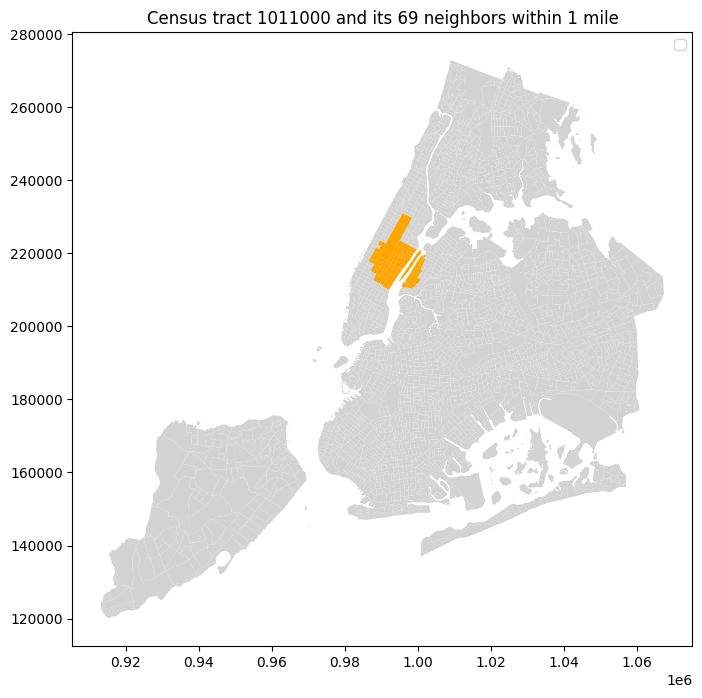

/var/folders/f3/ztq66ljn5nj08dv3xxk6xhwh0000gn/T/ipykernel_13938/2304854412.py:42: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf[gdf["tract_id"] == tid].plot(ax=ax, color="red", aspect=None, label="target")
/var/folders/f3/ztq66ljn5nj08dv3xxk6xhwh0000gn/T/ipykernel_13938/2304854412.py:45: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/f3/ztq66ljn5nj08dv3xxk6xhwh0000gn/T/ipykernel_13938/2304854412.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


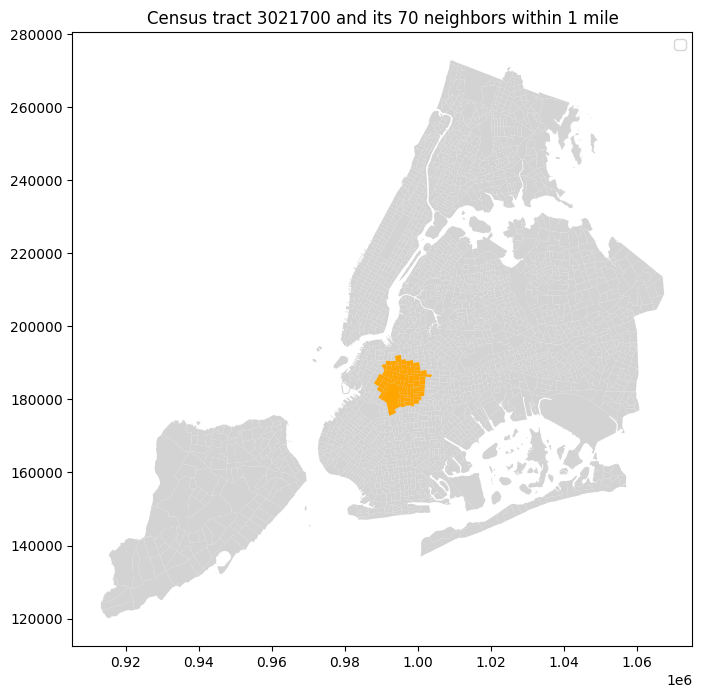

/var/folders/f3/ztq66ljn5nj08dv3xxk6xhwh0000gn/T/ipykernel_13938/2304854412.py:42: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf[gdf["tract_id"] == tid].plot(ax=ax, color="red", aspect=None, label="target")
/var/folders/f3/ztq66ljn5nj08dv3xxk6xhwh0000gn/T/ipykernel_13938/2304854412.py:45: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/f3/ztq66ljn5nj08dv3xxk6xhwh0000gn/T/ipykernel_13938/2304854412.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


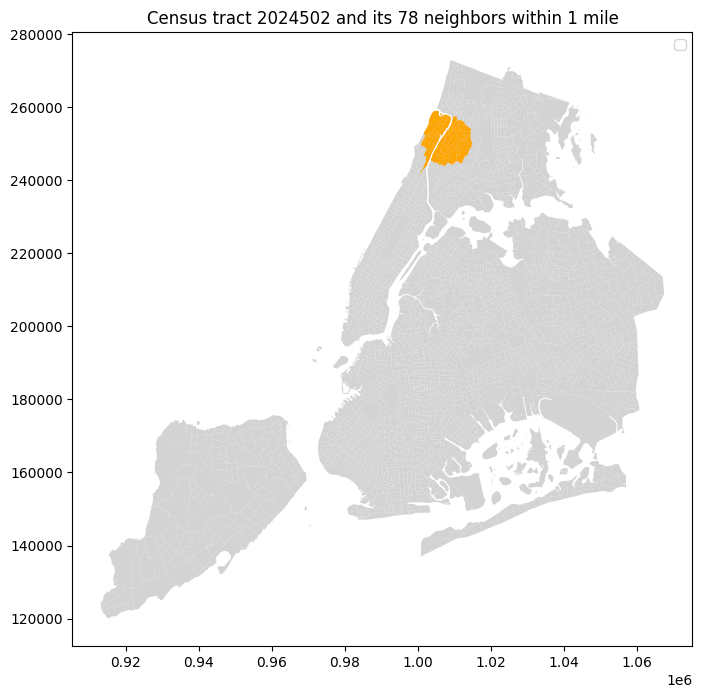

/var/folders/f3/ztq66ljn5nj08dv3xxk6xhwh0000gn/T/ipykernel_13938/2304854412.py:42: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf[gdf["tract_id"] == tid].plot(ax=ax, color="red", aspect=None, label="target")
/var/folders/f3/ztq66ljn5nj08dv3xxk6xhwh0000gn/T/ipykernel_13938/2304854412.py:45: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/f3/ztq66ljn5nj08dv3xxk6xhwh0000gn/T/ipykernel_13938/2304854412.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


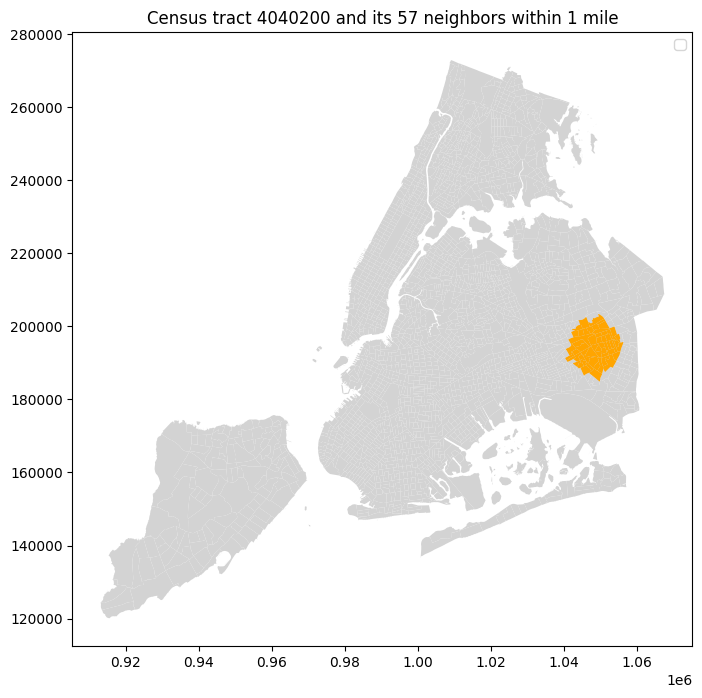

/var/folders/f3/ztq66ljn5nj08dv3xxk6xhwh0000gn/T/ipykernel_13938/2304854412.py:42: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf[gdf["tract_id"] == tid].plot(ax=ax, color="red", aspect=None, label="target")
/var/folders/f3/ztq66ljn5nj08dv3xxk6xhwh0000gn/T/ipykernel_13938/2304854412.py:45: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/f3/ztq66ljn5nj08dv3xxk6xhwh0000gn/T/ipykernel_13938/2304854412.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


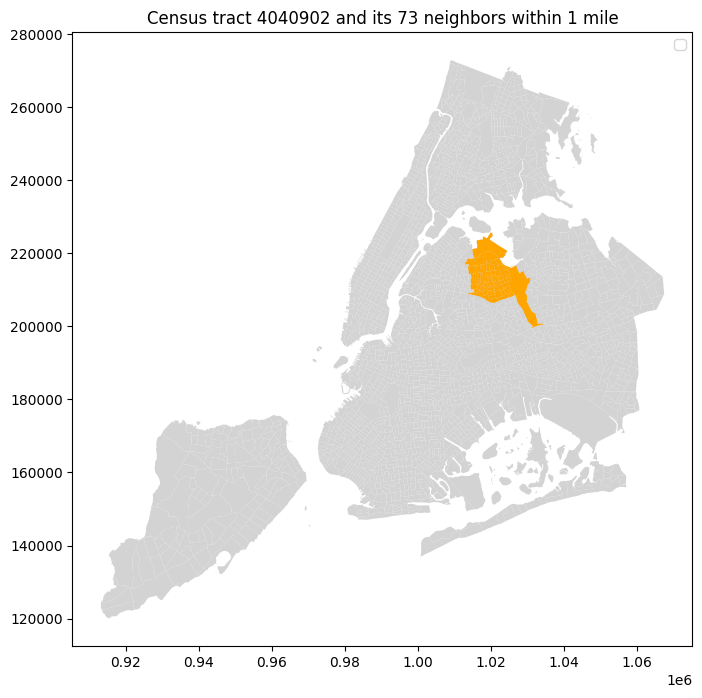

/var/folders/f3/ztq66ljn5nj08dv3xxk6xhwh0000gn/T/ipykernel_13938/2304854412.py:42: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf[gdf["tract_id"] == tid].plot(ax=ax, color="red", aspect=None, label="target")
/var/folders/f3/ztq66ljn5nj08dv3xxk6xhwh0000gn/T/ipykernel_13938/2304854412.py:45: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/f3/ztq66ljn5nj08dv3xxk6xhwh0000gn/T/ipykernel_13938/2304854412.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


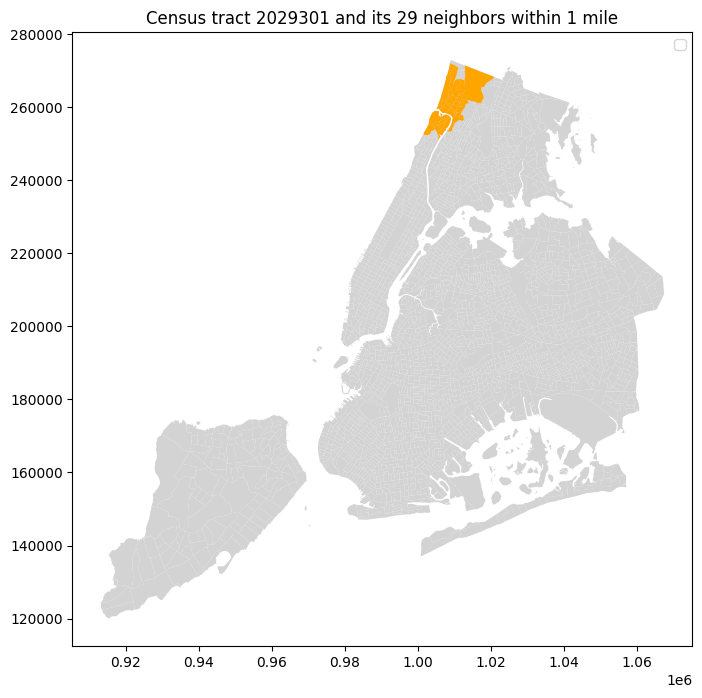

/var/folders/f3/ztq66ljn5nj08dv3xxk6xhwh0000gn/T/ipykernel_13938/2304854412.py:42: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf[gdf["tract_id"] == tid].plot(ax=ax, color="red", aspect=None, label="target")
/var/folders/f3/ztq66ljn5nj08dv3xxk6xhwh0000gn/T/ipykernel_13938/2304854412.py:45: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/f3/ztq66ljn5nj08dv3xxk6xhwh0000gn/T/ipykernel_13938/2304854412.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


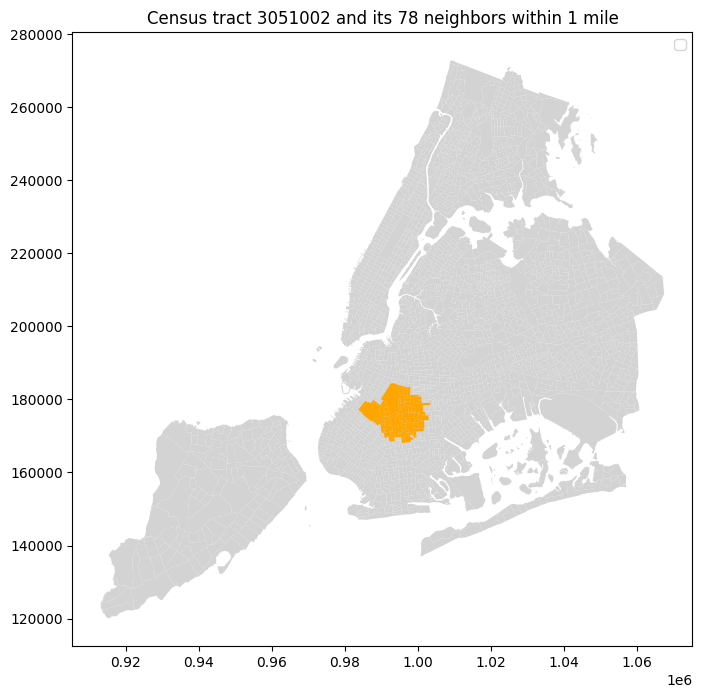

/var/folders/f3/ztq66ljn5nj08dv3xxk6xhwh0000gn/T/ipykernel_13938/2304854412.py:42: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf[gdf["tract_id"] == tid].plot(ax=ax, color="red", aspect=None, label="target")
/var/folders/f3/ztq66ljn5nj08dv3xxk6xhwh0000gn/T/ipykernel_13938/2304854412.py:45: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/f3/ztq66ljn5nj08dv3xxk6xhwh0000gn/T/ipykernel_13938/2304854412.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


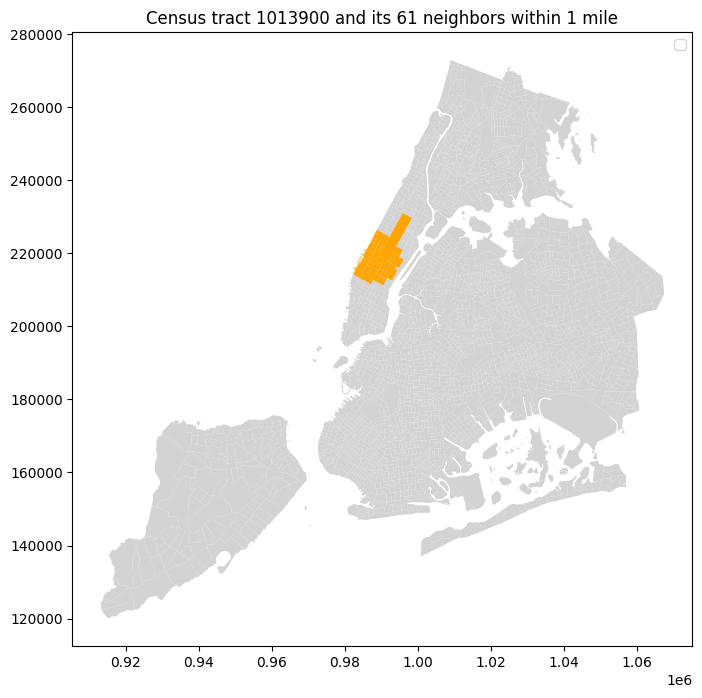

/var/folders/f3/ztq66ljn5nj08dv3xxk6xhwh0000gn/T/ipykernel_13938/2304854412.py:42: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf[gdf["tract_id"] == tid].plot(ax=ax, color="red", aspect=None, label="target")
/var/folders/f3/ztq66ljn5nj08dv3xxk6xhwh0000gn/T/ipykernel_13938/2304854412.py:45: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/f3/ztq66ljn5nj08dv3xxk6xhwh0000gn/T/ipykernel_13938/2304854412.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


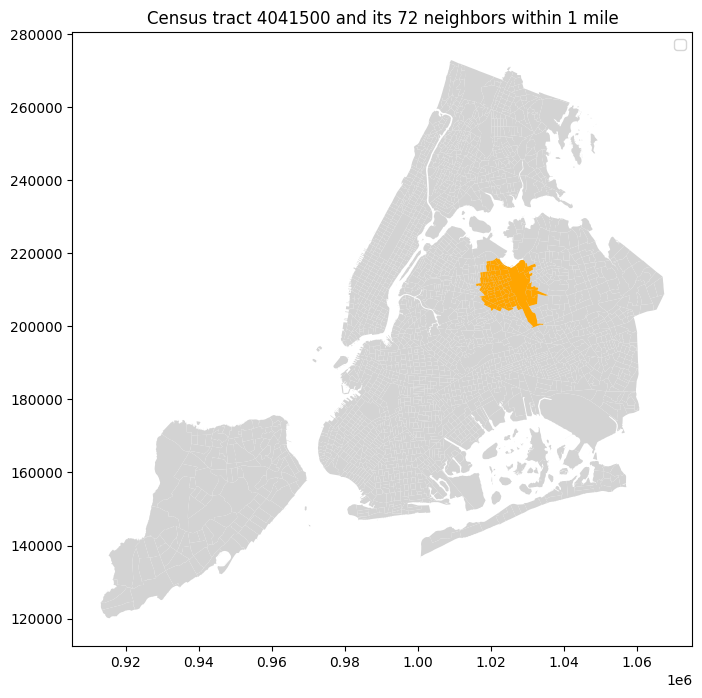

/var/folders/f3/ztq66ljn5nj08dv3xxk6xhwh0000gn/T/ipykernel_13938/2304854412.py:42: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf[gdf["tract_id"] == tid].plot(ax=ax, color="red", aspect=None, label="target")
/var/folders/f3/ztq66ljn5nj08dv3xxk6xhwh0000gn/T/ipykernel_13938/2304854412.py:45: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/f3/ztq66ljn5nj08dv3xxk6xhwh0000gn/T/ipykernel_13938/2304854412.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


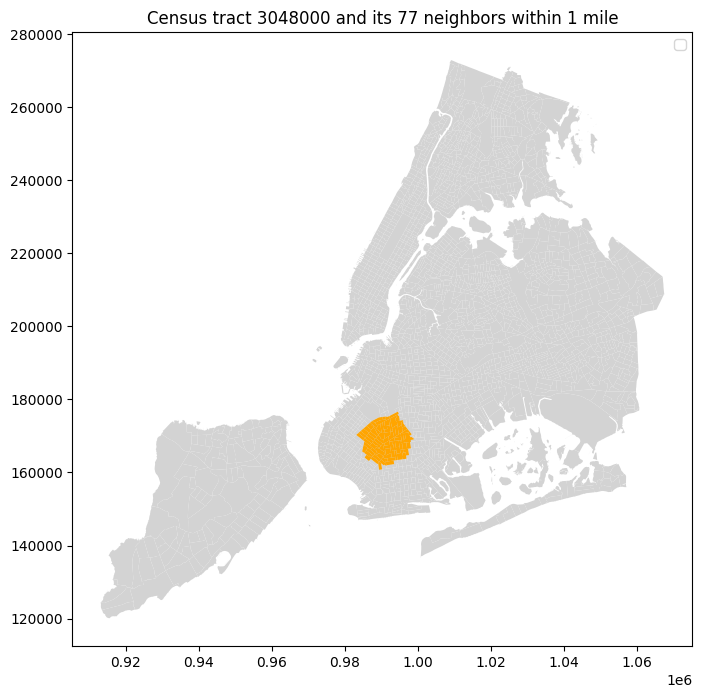

In [45]:
# === Plot 10 random tracts + their neighbors (auto-randomized each run) ===
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import random

# Load tracts and precomputed neighbors
gdf = gpd.read_file("nyc_tracts/nyc_tracts.json")
if gdf.crs is None:
    gdf.set_crs(epsg=2263, inplace=True)
if "BoroCT2020" in gdf.columns:
    gdf["tract_id"] = gdf["BoroCT2020"].astype(str).str.zfill(7)
else:
    # Derive from GEOID if missing
    def derive_boroct_from_geoid(geoid: str) -> str:
        county_to_boro = {"061": "1", "005": "2", "047": "3", "081": "4", "085": "5"}
        geoid = str(geoid)
        return county_to_boro[geoid[2:5]] + geoid[5:11]
    gdf["tract_id"] = gdf["GEOID"].astype(str).apply(derive_boroct_from_geoid)

gdf = gdf[["tract_id", "geometry"]].drop_duplicates(subset="tract_id").reset_index(drop=True)

# Load your new neighbor CSV
neighbors_df = pd.read_csv("nyc_tract_neighbors_1mile_boroct.csv")
neighbors_df["neighbor_ids"] = neighbors_df["neighbor_ids"].astype(str)

# Random seed that changes each run
random.seed(None)  # new seed per run

# Pick 10 random tracts
samples = random.sample(list(neighbors_df["tract_id"]), 10)

# Plot each tract + its neighbors
for tid in samples:
    neighbor_ids = neighbors_df.loc[
        neighbors_df["tract_id"] == tid, "neighbor_ids"
    ].iloc[0].split(",")

    fig, ax = plt.subplots(figsize=(8, 8))
    gdf.plot(ax=ax, color="lightgray", linewidth=0.3, aspect=None)
    gdf[gdf["tract_id"].isin(neighbor_ids)].plot(ax=ax, color="orange", linewidth=0.5, aspect=None, label="neighbors")
    gdf[gdf["tract_id"] == tid].plot(ax=ax, color="red", aspect=None, label="target")
    ax.set_aspect("equal")
    plt.title(f"Census tract {tid} and its {len(neighbor_ids)} neighbors within 1 mile")
    plt.legend()
    plt.show()
